<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/CaseWithMean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install "git+https://github.com/Karasiari/HuGraphFinal.git"

  Cloning https://github.com/Karasiari/HuGraphFinal.git to /tmp/pip-req-build-uj8f2n9q
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/HuGraphFinal.git /tmp/pip-req-build-uj8f2n9q
  Resolved https://github.com/Karasiari/HuGraphFinal.git to commit 5ae64a65805a00441d144f26bd599ba05ed8ebd8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hugraphfin: filename=hugraphfin-0.1.0-py3-none-any.whl size=65926 sha256=a954e59bc1f762e714e1ed0eff894bd79713e73d982df40729ec0beb91509c56
  Stored in directory: /tmp/pip-ephem-wheel-cache-c9w3nvtw/wheels/46/83/89/572a6db8e6320eb877bf6ced236fa61f993538a12c5e43c72e
Successfully built hugraphfin


In [2]:
# чтобы не падал ecos
%pip install ecos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
from graph_exps.traffic_generation.generation_for_exp import generate_own_traffic
from graph_exps.SNRBA_generation.generation import generate_snr_ba_graph

import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Список для хранения всех DataFrame
all_dfs = []

def small_test_table(num_tests: int):
  available_demand_volumes = ((1, 0.9), (2, 0.1))
  capacity_value = 80.0

  additional_resources = [capacity_value] * 3
  allocation_types = ['alpha', 'random_alpha', 'random']
  additional_resources.sort(reverse=True)
  result_dict = {}
  for i in range(num_tests):
    snr_ba_graph = generate_snr_ba_graph(num_nodes=25, capacity_value=capacity_value, random_seed=42+i)

    adj_graph_alpha, traffic_graph_alpha =  generate_own_traffic(
    snr_ba_graph,
    available_demand_volumes,
    generation_type="alpha_with_sa",
    generation_params={"alpha_target": 0.35, "epsilon": 0.025, "median_weight_for_initial": 20, "var_for_initial": 1, "multi_max": 5, "t": 0.5}
    )
    graph_for_exp_alpha = HuGraphForExps(adj_graph_alpha, traffic_graph_alpha)

    results_alpha = expand_test_for_graph(
        graph=graph_for_exp_alpha,
        additional_resources=additional_resources,
        allocation_types=allocation_types,
        tries_for_allocation=15,
        epsilon=1.2,
        available_volumes=available_demand_volumes
    )
    df = results_alpha
    df['experiment'] = f'exp_{i}'
    df['type'] = df.index.get_level_values(0)
    all_dfs.append(df.copy())

In [ ]:
small_test_table(10)

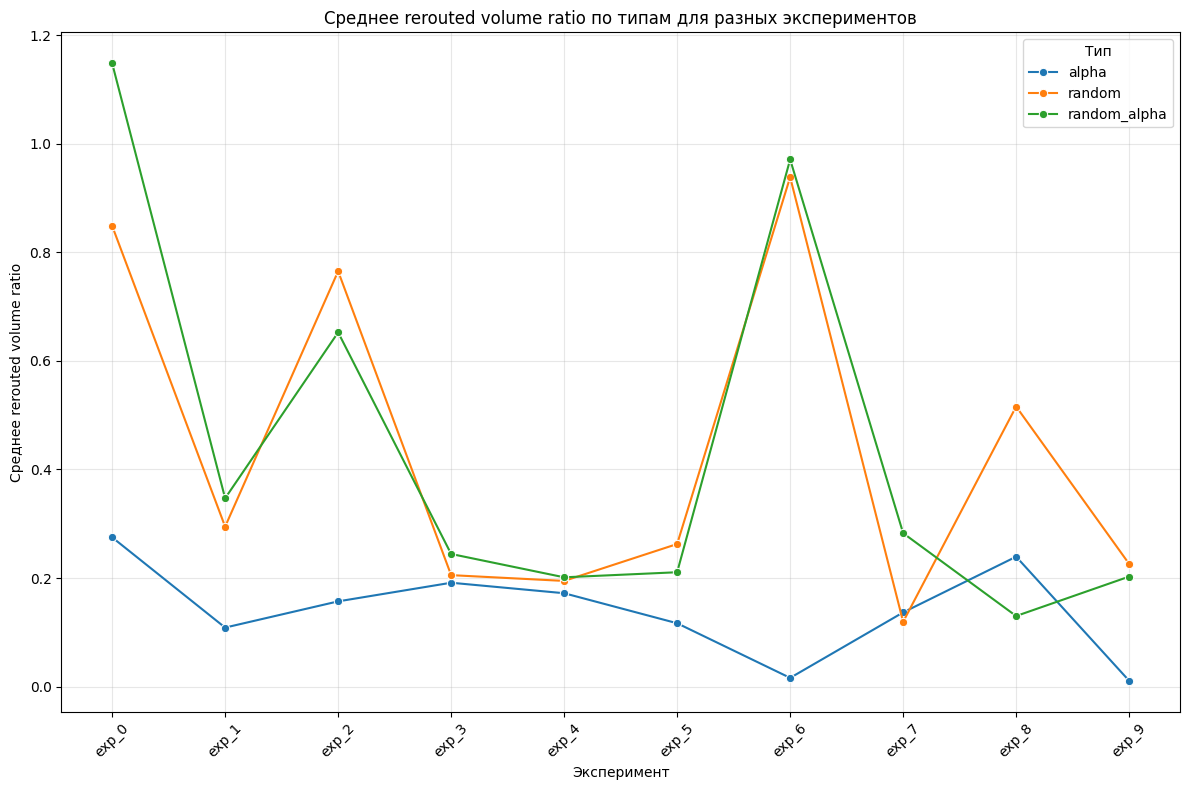

In [ ]:
# Объединяем все DataFrame
combined_df = pd.concat(all_dfs, ignore_index=False)

# Считаем средние по типам для каждого эксперимента
average_by_type_exp = combined_df.groupby(['experiment', 'type'])['rerouted volume ratio'].mean().reset_index()

# Строим график
plt.figure(figsize=(12, 8))
sns.lineplot(data=average_by_type_exp, x='experiment', y='rerouted volume ratio', hue='type', marker='o')
plt.title('Среднее rerouted volume ratio по типам для разных экспериментов')
plt.xlabel('Эксперимент')
plt.ylabel('Среднее rerouted volume ratio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title='Тип')
plt.tight_layout()
plt.show()

In [9]:
from graph_exps.exp import *
import pandas as pd
import numpy as np

def custom_expand_network_for_type(graph, edges_with_alphas, resources_to_add, allocation_type):
  edges_expanded = []
  number_of_new_resources = len(resources_to_add)
  if allocation_type == "alpha":
    edges_with_alphas.sort(key=lambda x: x[1], reverse=True)
    edges_to_expand = [edge for edge, _ in edges_with_alphas[:number_of_new_resources]]
    source_target_sequence_for_new_resources = list(zip(edges_to_expand, resources_to_add))
    edges_expanded = [(edge, alpha) for edge, alpha in edges_with_alphas[:number_of_new_resources]]

  elif allocation_type == "random_alpha":
    random.shuffle(edges_with_alphas)
    edges_to_expand = edges_with_alphas[:number_of_new_resources]
    edges_to_expand.sort(key=lambda x: x[1], reverse=True)
    edges_to_expand = [edge for edge, _ in edges_to_expand]
    source_target_sequence_for_new_resources = list(zip(edges_to_expand, resources_to_add))
    edges_expanded = [(edge, alpha) for edge, alpha in edges_with_alphas[:number_of_new_resources]]

  elif allocation_type == "random":
    random.shuffle(edges_with_alphas)
    edges_to_expand = [edge for edge, _ in edges_with_alphas[:number_of_new_resources]]
    source_target_sequence_for_new_resources = list(zip(edges_to_expand, resources_to_add))
    edges_expanded = [(edge, alpha) for edge, alpha in edges_with_alphas[:number_of_new_resources]]
  else:
    raise ValueError(f"Тип распределения ресурсов {allocation_type} не предусмотрен экспериментом")

  graph_copy_to_expand = graph.copy()
  expanded_graph = expand_graph(graph_copy_to_expand, source_target_sequence_for_new_resources)
  return expanded_graph, edges_expanded


def calculate_edge_distribution(all_edges, selected_edges) -> Tuple[float, float]:
    selected_weights = [weight for (_, _), weight in selected_edges]
    min_selected = min(selected_weights)
    max_selected = max(selected_weights)

    all_weights = [weight for (_, _), weight in all_edges]
    n = len(all_weights)

    sorted_weights = sorted(all_weights)

    import bisect

    smaller_count = bisect.bisect_left(sorted_weights, min_selected)

    larger_start = bisect.bisect_right(sorted_weights, max_selected)
    larger_count = n - larger_start

    smaller_fraction = smaller_count / n
    larger_fraction = larger_count / n

    return smaller_fraction, larger_fraction


def join_dict_to_dataframe(df: pd.DataFrame, dict_data: dict, tuple_index_level: int = 0, new_col_names: tuple = ('min_alpha', 'max_alpha')):
    result_df = df.copy()
    original_index = result_df.index
    if isinstance(original_index, pd.MultiIndex):
        types = original_index.get_level_values(tuple_index_level)
    else:
        types = original_index
    if isinstance(types[0], tuple):
        type_names = [t[0] for t in types]
    else:
        type_names = list(types)
    first_values = []
    second_values = []
    for type_name in type_names:
        if type_name in dict_data:
            first_values.append(dict_data[type_name][0])
            second_values.append(dict_data[type_name][1])
        else:
            first_values.append(None)
            second_values.append(None)
    result_df[new_col_names[0]] = first_values
    result_df[new_col_names[1]] = second_values
    return result_df


def alpha_pref_test(graph: HuGraphForExps, additional_resources, allocation_types, available_demand_volumes):
  def get_edge_key(edge):
    u, v = edge
    return (min(u, v), max(u, v))
  edges_with_alphas_unkeyd = compute_alpha_for_all_edges(graph)
  edges_with_alphas = [(get_edge_key(edge), alpha) for edge, alpha in edges_with_alphas_unkeyd]
  route_result, demands, _, multidigraph = graph.solve_mcf()
  expanded_graphs = {}
  edges_expanded = {}
  resources_dict={}
  for allocation_type in allocation_types:
    expanded_graphs[allocation_type], edges_expanded[allocation_type]  = custom_expand_network_for_type(multidigraph, edges_with_alphas, additional_resources, allocation_type)
  for allocation_type, selected_edges in edges_expanded.items():
    resources_dict[allocation_type] = calculate_edge_distribution(edges_with_alphas, selected_edges)
  edges_for_remaining_networks = get_edges_for_remaining_networks(expanded_graphs, remaining_networks_pref="all", route_result=route_result, demands=demands)
  allocation_results_raw = allocation_test(expanded_graphs, route_result, demands, edges_for_remaining_networks, tries_for_allocation=10, epsilon=1.2, available_volumes=available_demand_volumes, random_seed=None)
  allocation_results = get_right_output(allocation_results_raw)
  result = join_dict_to_dataframe(allocation_results, resources_dict)
  return result

In [31]:
from graph_exps.traffic_generation.generation_for_exp import generate_own_traffic
from graph_exps.SNRBA_generation.generation import generate_snr_ba_graph
from graph_exps.readers.hugraph_reader import read_hu_graphs

def get_graphs(num, type, capacity_value, names=None):
  graphs = []
  if type == "snr":
    for i in range(num):
      graph = generate_snr_ba_graph(num_nodes=35, capacity_value=capacity_value, random_seed=42+i)
      graphs.append(graph)
  elif type == "hu":
    hu_graphs = read_hu_graphs('/content/drive/MyDrive/Кола', names, True)
    for name, graph_data in hu_graphs.items():
      adj_graph_hu, _ = hu_graphs[name]['adj_graph'], hu_graphs[name]['traffic_graph']
      for i in range(num):
        graphs.append(adj_graph_hu)
  return graphs


def small_alpha_test(graphs_for_tests, capacity_value, available_demand_volume, additional_resources, allocation_types):
  experiment_dfs = []
  for graph in graphs_for_tests:
    adj_graph_alpha, traffic_graph_alpha =  generate_own_traffic(
    graph,
    available_demand_volumes,
    generation_type="alpha_with_sa",
    generation_params={"alpha_target": 0.35, "epsilon": 0.025, "median_weight_for_initial": 20, "var_for_initial": 1, "multi_max": 5, "t": 0.5}
    )
    graph_for_exp_alpha = HuGraphForExps(adj_graph_alpha, traffic_graph_alpha)
    experiment_dfs.append(alpha_pref_test(graph_for_exp_alpha, additional_resources, allocation_types, available_demand_volumes))
  return experiment_dfs

available_demand_volumes = ((1, 0.9), (2, 0.1))
capacity_value = 80.0
additional_resources = [capacity_value] * 5
allocation_types = ['alpha', 'random_alpha', 'random']
additional_resources.sort(reverse=True)

In [ ]:
snr_graphs_for_test = get_graphs(10, "snr", capacity_value)
experiment_dfs_snr = small_alpha_test(snr_graphs_for_test, capacity_value, available_demand_volumes, additional_resources, allocation_types)

In [ ]:
hu_graphs_for_test = get_graphs(10, "hu", capacity_value, "cola_t3")
experiment_dfs_hu = small_alpha_test(hu_graphs_for_test, capacity_value, available_demand_volumes, additional_resources, allocation_types)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def plot_experiment_results(experiment_dfs,
                           rerouted_col='rerouted volume ratio',
                           tuple_cols=('min_alpha', 'max_alpha')):
    """
    Строит два графика:
    1. Средний rerouted volume ratio по типам для каждого эксперимента
    2. min_alpha и max_alpha по типам (похожие цвета для одного типа)
    """

    # Подготовка данных
    all_data = []

    for exp_id, df in enumerate(experiment_dfs):
        df_copy = df.copy()

        # Извлекаем тип из индекса
        if isinstance(df_copy.index, pd.MultiIndex):
            df_copy['type'] = df_copy.index.get_level_values(0)
        else:
            df_copy['type'] = df_copy.index

        if isinstance(df_copy['type'].iloc[0], tuple):
            df_copy['type'] = df_copy['type'].apply(lambda x: x[0])

        df_copy['experiment'] = exp_id
        all_data.append(df_copy)

    combined_df = pd.concat(all_data, ignore_index=True)

    # Проверка столбцов
    required_cols = [rerouted_col, 'type', 'experiment'] + list(tuple_cols)
    missing_cols = [col for col in required_cols if col not in combined_df.columns]
    if missing_cols:
        print(f"Отсутствуют столбцы: {missing_cols}")
        return

    # Уникальные типы и эксперименты
    unique_types = sorted(combined_df['type'].unique())
    experiment_ids = sorted(combined_df['experiment'].unique())

    # Создаем фигуру
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Используем разные цветовые палитры для разнообразия
    n_types = len(unique_types)

    # Вариант 1: Используем близкие цвета из одного семейства
    base_colors = cm.viridis(np.linspace(0.2, 0.8, n_types))

    # Создаем похожие цвета для min_alpha и max_alpha
    type_colors = []
    for base_color in base_colors:
        # Делаем два похожих оттенка
        light_color = np.array(base_color) * 0.8  # Светлее
        light_color[3] = 0.9  # Альфа-канал

        dark_color = np.array(base_color) * 1.2  # Темнее
        dark_color = np.clip(dark_color, 0, 1)
        dark_color[3] = 0.9

        type_colors.append((light_color, dark_color))

    # График 1: Средний rerouted volume ratio
    for i, typ in enumerate(unique_types):
        type_data = combined_df[combined_df['type'] == typ]
        exp_means = type_data.groupby('experiment')[rerouted_col].mean().sort_index()

        # Используем средний цвет для основного графика
        main_color = (type_colors[i][0] + type_colors[i][1]) / 2

        ax1.plot(exp_means.index, exp_means.values,
                marker='o', label=typ,
                color=main_color, linewidth=2, markersize=6,
                markerfacecolor='white', markeredgewidth=1.5)

    ax1.set_title(f'Средний {rerouted_col} по экспериментам')
    ax1.set_xlabel('Номер эксперимента')
    ax1.set_ylabel(rerouted_col)
    ax1.set_xticks(experiment_ids)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3, linestyle=':')

    # График 2: min_alpha и max_alpha
    line_styles = ['-', '--']
    markers = ['s', '^']

    for i, typ in enumerate(unique_types):
        type_data = combined_df[combined_df['type'] == typ]
        exp_data = type_data.groupby('experiment').first()

        # Две линии для каждого типа
        for j, col in enumerate(tuple_cols):
            line_color = type_colors[i][j]  # Разные, но похожие цвета
            ax2.plot(exp_data.index, exp_data[col],
                    marker=markers[j], linestyle=line_styles[j],
                    label=f'{typ} - {col}' if j == 0 else '',
                    color=line_color, linewidth=2, markersize=6,
                    markerfacecolor='white', markeredgewidth=1.5)

    ax2.set_title(f'{tuple_cols[0]} и {tuple_cols[1]} по типам')
    ax2.set_xlabel('Номер эксперимента')
    ax2.set_ylabel('Значения alpha')
    ax2.set_xticks(experiment_ids)
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3, linestyle=':')

    plt.tight_layout()
    plt.show()

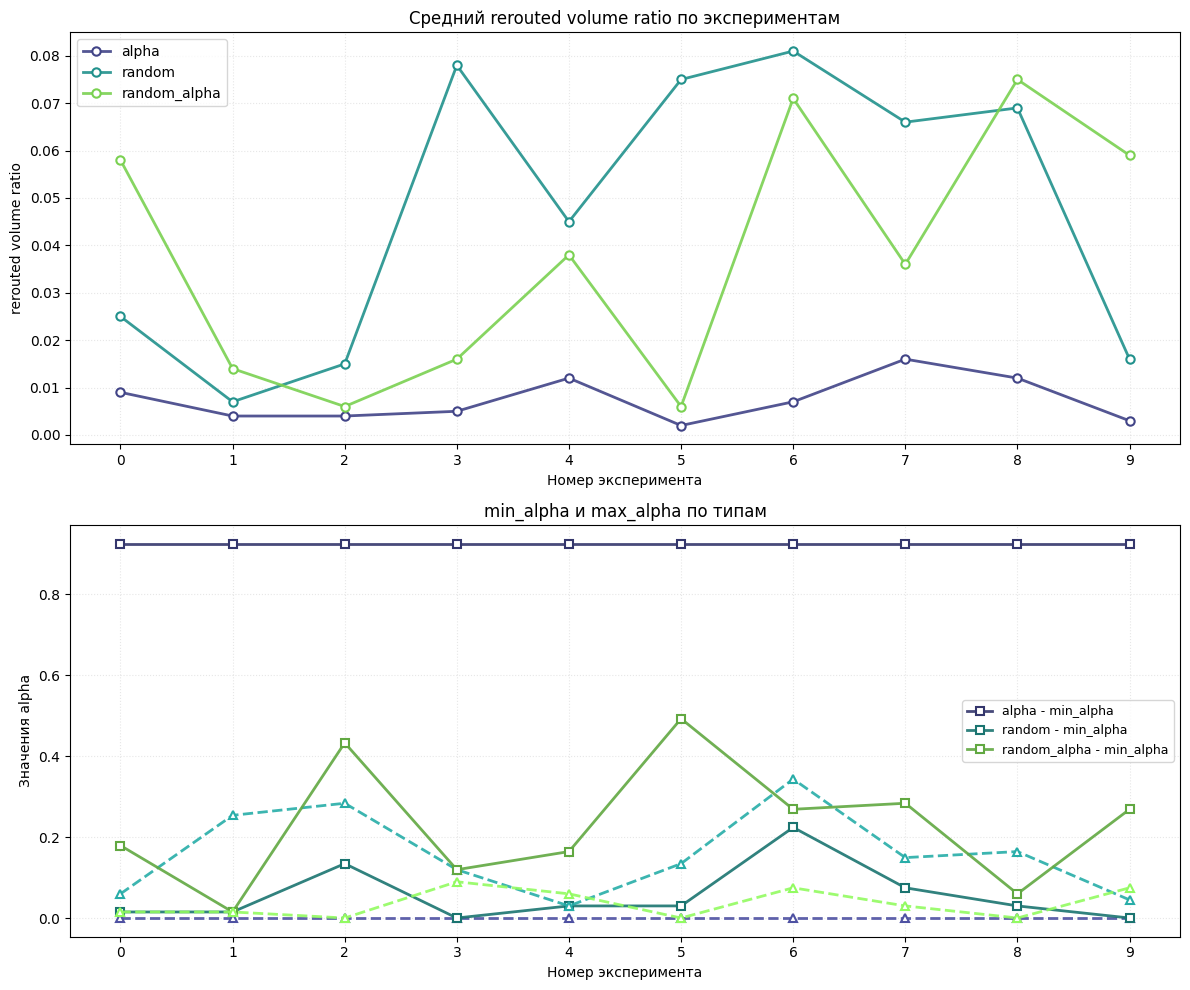

In [35]:
plot_experiment_results(experiment_dfs_snr)

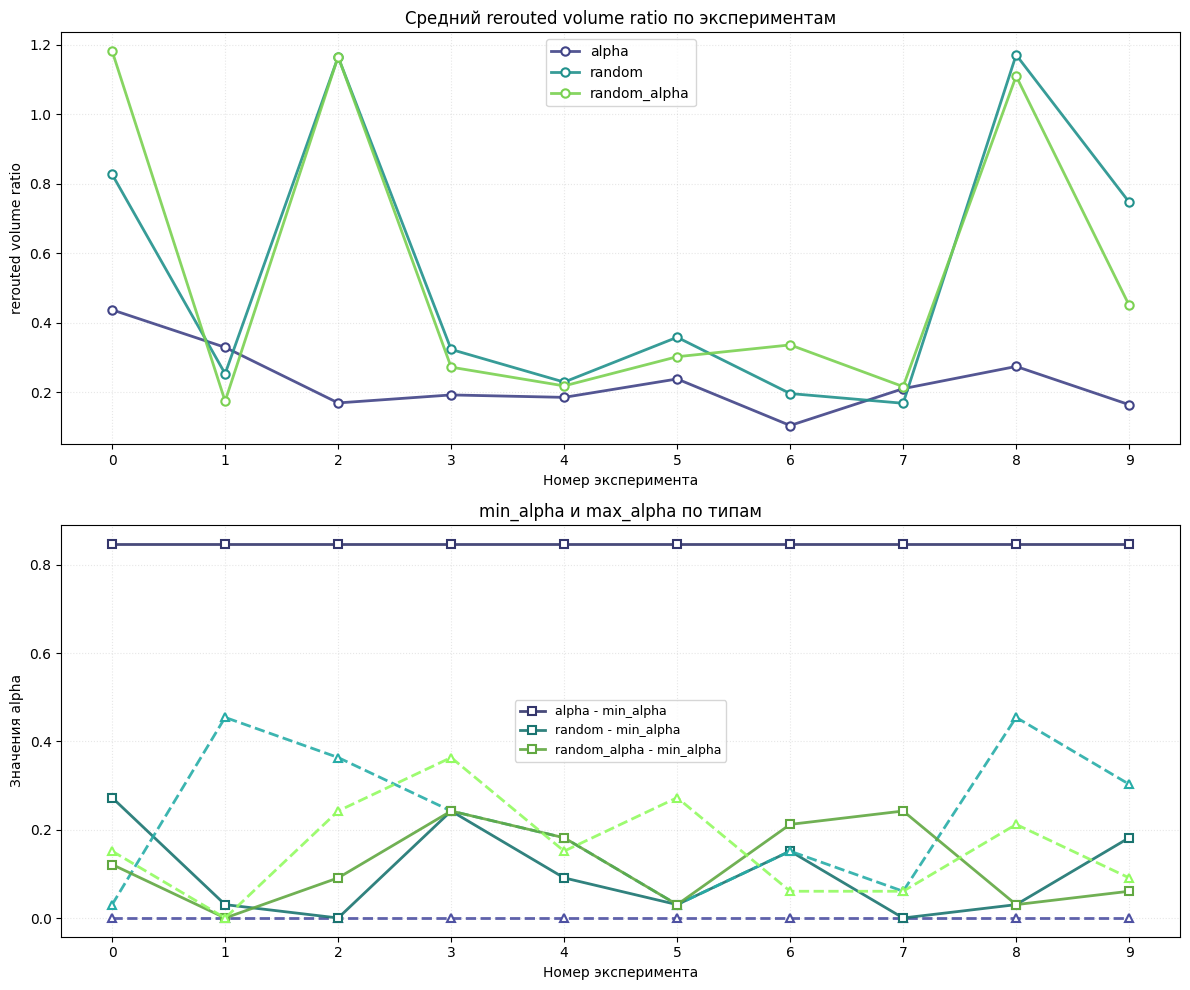

In [36]:
plot_experiment_results(experiment_dfs_hu)

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def plot_experiment_results_new(experiment_dfs,
                           rerouted_col='rerouted volume ratio',
                           tuple_cols=('inside_range_fraction', 'max_alpha')):
    """
    Строит два графика:
    1. Средний rerouted volume ratio по типам для каждого эксперимента
    2. Доля ВНУТРИ диапазона (1 - min_alpha - max_alpha) и max_alpha по типам
    """

    # Подготовка данных
    all_data = []

    for exp_id, df in enumerate(experiment_dfs):
        df_copy = df.copy()

        # Извлекаем тип из индекса
        if isinstance(df_copy.index, pd.MultiIndex):
            df_copy['type'] = df_copy.index.get_level_values(0)
        else:
            df_copy['type'] = df_copy.index

        if isinstance(df_copy['type'].iloc[0], tuple):
            df_copy['type'] = df_copy['type'].apply(lambda x: x[0])

        df_copy['experiment'] = exp_id
        all_data.append(df_copy)

    combined_df = pd.concat(all_data, ignore_index=True)

    # Проверка столбцов
    required_cols = [rerouted_col, 'type', 'experiment', 'min_alpha', 'max_alpha']
    missing_cols = [col for col in required_cols if col not in combined_df.columns]
    if missing_cols:
        print(f"Отсутствуют столбцы: {missing_cols}")
        print(f"Доступные столбцы: {combined_df.columns.tolist()}")
        return

    # Рассчитываем долю ВНУТРИ диапазона
    combined_df['inside_range_fraction'] = 1 - combined_df['min_alpha'] - combined_df['max_alpha']

    # Уникальные типы и эксперименты
    unique_types = sorted(combined_df['type'].unique())
    experiment_ids = sorted(combined_df['experiment'].unique())

    # Создаем фигуру
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Используем разные цветовые палитры для разнообразия
    n_types = len(unique_types)

    # Вариант 1: Используем близкие цвета из одного семейства
    base_colors = cm.viridis(np.linspace(0.2, 0.8, n_types))

    # Создаем похожие цвета для inside_range_fraction и max_alpha
    type_colors = []
    for base_color in base_colors:
        # Делаем два похожих оттенка
        light_color = np.array(base_color) * 0.8  # Светлее
        light_color[3] = 0.9  # Альфа-канал

        dark_color = np.array(base_color) * 1.2  # Темнее
        dark_color = np.clip(dark_color, 0, 1)
        dark_color[3] = 0.9

        type_colors.append((light_color, dark_color))

    # График 1: Средний rerouted volume ratio
    for i, typ in enumerate(unique_types):
        type_data = combined_df[combined_df['type'] == typ]
        exp_means = type_data.groupby('experiment')[rerouted_col].mean().sort_index()

        # Используем средний цвет для основного графика
        main_color = (type_colors[i][0] + type_colors[i][1]) / 2

        ax1.plot(exp_means.index, exp_means.values,
                marker='o', label=typ,
                color=main_color, linewidth=2, markersize=6,
                markerfacecolor='white', markeredgewidth=1.5)

    ax1.set_title(f'Средний {rerouted_col} по экспериментам')
    ax1.set_xlabel('Номер эксперимента')
    ax1.set_ylabel(rerouted_col)
    ax1.set_xticks(experiment_ids)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3, linestyle=':')

    # График 2: inside_range_fraction и max_alpha
    line_styles = ['-', '--']
    markers = ['s', '^']
    legend_labels = ['Доля внутри диапазона', 'max_alpha']

    for i, typ in enumerate(unique_types):
        type_data = combined_df[combined_df['type'] == typ]

        # Группируем по экспериментам и берем средние
        exp_means_inside = type_data.groupby('experiment')['inside_range_fraction'].mean().sort_index()
        exp_means_max = type_data.groupby('experiment')['max_alpha'].mean().sort_index()

        # Линия для доли ВНУТРИ диапазона
        line_color = type_colors[i][0]
        ax2.plot(exp_means_inside.index, exp_means_inside.values,
                marker=markers[0], linestyle=line_styles[0],
                label=f'{typ} - {legend_labels[0]}' if i == 0 else '',
                color=line_color, linewidth=2, markersize=6,
                markerfacecolor='white', markeredgewidth=1.5)

        # Линия для max_alpha
        line_color = type_colors[i][1]
        ax2.plot(exp_means_max.index, exp_means_max.values,
                marker=markers[1], linestyle=line_styles[1],
                label=f'{typ} - {legend_labels[1]}' if i == 0 else '',
                color=line_color, linewidth=2, markersize=6,
                markerfacecolor='white', markeredgewidth=1.5)

    ax2.set_title('Доля значений внутри диапазона [min_alpha, max_alpha] и max_alpha')
    ax2.set_xlabel('Номер эксперимента')
    ax2.set_ylabel('Значение')
    ax2.set_xticks(experiment_ids)

    # Упрощаем легенду
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='s', color='gray', label='Доля внутри диапазона',
               markerfacecolor='white', markeredgewidth=1.5, linestyle='-'),
        Line2D([0], [0], marker='^', color='gray', label='max_alpha',
               markerfacecolor='white', markeredgewidth=1.5, linestyle='--'),
    ]

    # Добавляем легенду типов
    for i, typ in enumerate(unique_types):
        legend_elements.append(
            Line2D([0], [0], color=type_colors[i][0], lw=2, label=typ)
        )

    ax2.legend(handles=legend_elements, loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3, linestyle=':')

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-4217266009.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['inside_range_fraction'] = 1 - combined_df['min_alpha'] - combined_df['max_alpha']


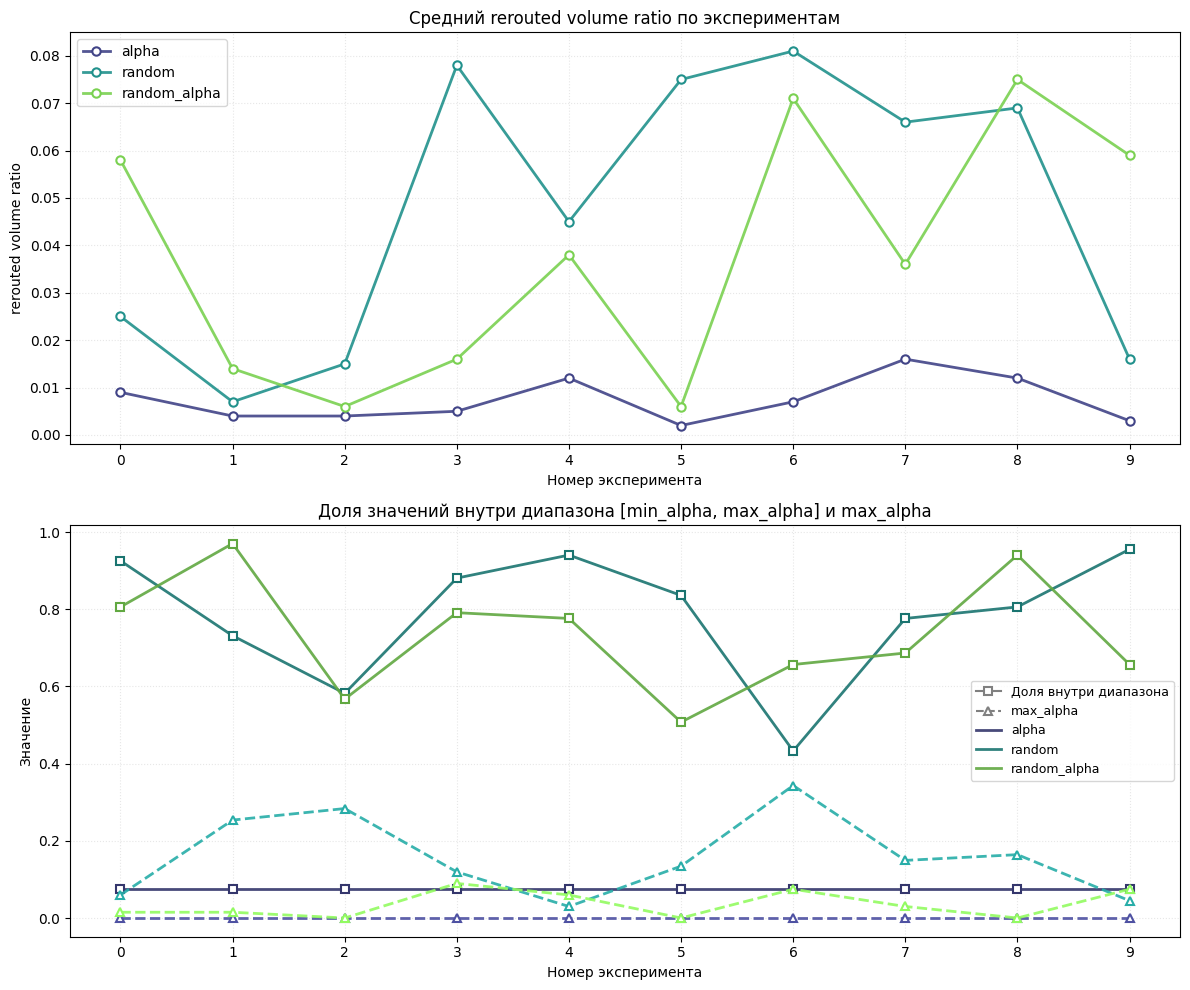

In [38]:
plot_experiment_results_new(experiment_dfs_snr)

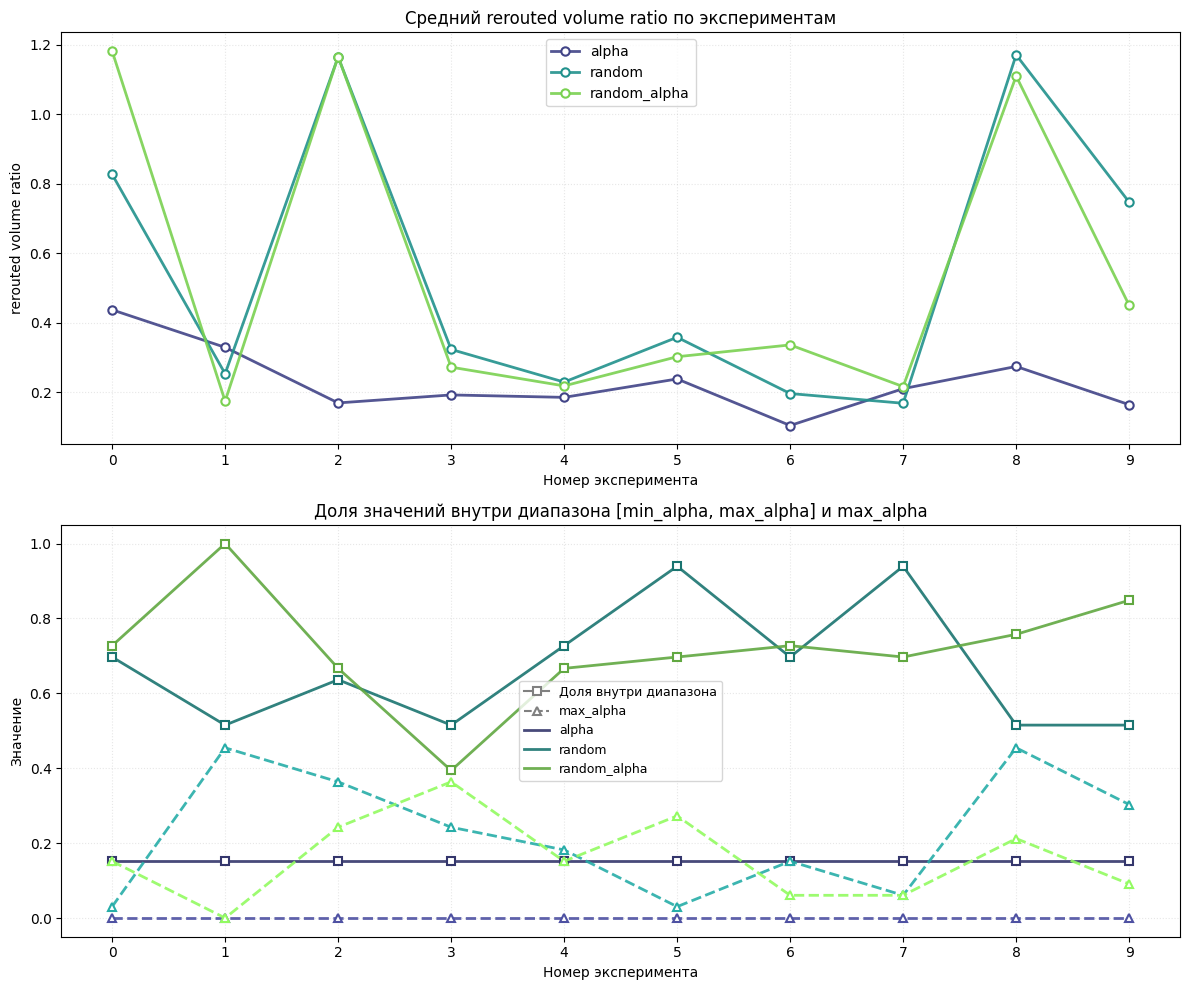

In [39]:
plot_experiment_results_new(experiment_dfs_hu)